## For Colab only

In [1]:
!git clone https://github.com/maftukh/news_classifier.git

Cloning into 'news_classifier'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 36 (delta 13), reused 18 (delta 6), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [2]:
!ls news_classifier/

bert_classification_model.ipynb		      data     evals.py  optim.py
bert_classification_model_with_modules.ipynb  data.py  model.py  README.md


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Fix the path to get the correct model
!mkdir ./news_classifier/model/
!cp /content/gdrive/MyDrive/data/news_cat/model/finetuned_pytorch_model_32_ep5.bin ./news_classifier/model/

## Imports

In [5]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 123 kB 5.4 MB/s 
     |████████████████████████████████| 132 kB 44.3 MB/s 
     |████████████████████████████████| 8.7 MB 46.2 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 138 kB 49.1 MB/s 
     |████████████████████████████████| 127 kB 46.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [6]:
import os
import sys
import random
from pathlib import Path

# Third-party packages
import numpy as np
import pandas as pd
from pytorch_pretrained_bert.tokenization import BertTokenizer
import torch
from tqdm.notebook import tqdm, trange

sys.path.append('/content/news_classifier')

# Custom imports
import model
import data
import evals
import optim



In [7]:
# To make sure custom modules are up-to-date by the time of each call
%load_ext autoreload
%autoreload 2

## Model Parameters

In [8]:
DATA_PATH = Path('news_classifier/data/')
MODEL_PATH = Path('news_classifier/model/')

args = {
    "data_dir": DATA_PATH,
    "output_dir": MODEL_PATH,
    "ckpt_name": 'pretrain.ckpt', # Файл с которого хочется продолжить обучение
    
    "task_name": "news_cat_label",
    "bert_model": 'bert-base-uncased',  # оптимальная моделька с точки зрения веса, вряд ли стоит менять
    "do_lower_case": True,
    
    "max_seq_length": 32, # Сколько слов из колонки 'text' используется в модели
    "batch_size": 128, # размер батча на входе в модель
    'eval_steps': 500, # Через сколько шагов делать промежуточную оценку модели
    
    "learning_rate": 3e-5,
    "num_train_epochs": 5.0,
    "warmup_proportion": 0., # При .1 - первые 10% шагов обучения будут плавными, чтоб избежать взрыва градиентов 

    "no_cuda": False, # Если есть cuda, но почему-то не хочешь юзать
    "seed": 42,
}



In [9]:
def set_random_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [10]:
# Setup GPU parameters
args['device'] = torch.device("cuda" if torch.cuda.is_available() and not args["no_cuda"] else "cpu")

set_random_seeds(args['seed'])

In [11]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
args['logger'] = logging.getLogger(__name__)

In [16]:
# args['label_list'] = np.sort(df.category.unique()) - в будущем для обучения лучше так. У меня просто модель со след списком обучилась:
args['label_list'] = ['ENTERTAINMENT', 'WORLD NEWS', 'OTHER', 'POLITICS', 'WOMEN', 'SPORTS',
       'BUSINESS', 'TRAVEL', 'TECH', 'RELIGION', 'SCIENCE', 'ARTS', 'STYLE',
       'ENVIRONMENT', 'FOOD & DRINK', 'HEALTHY LIVING', 'HOME & LIVING',
       'MONEY']
args['num_labels'] = len(args['label_list'])
args['num_labels'], args['label_list']    

(18,
 ['ENTERTAINMENT',
  'WORLD NEWS',
  'OTHER',
  'POLITICS',
  'WOMEN',
  'SPORTS',
  'BUSINESS',
  'TRAVEL',
  'TECH',
  'RELIGION',
  'SCIENCE',
  'ARTS',
  'STYLE',
  'ENVIRONMENT',
  'FOOD & DRINK',
  'HEALTHY LIVING',
  'HOME & LIVING',
  'MONEY'])

In [17]:
processor = data.LabelTextProcessor(args['data_dir'], labels=args['label_list'])
tokenizer = BertTokenizer.from_pretrained(args['bert_model'], do_lower_case=args['do_lower_case'])

04/08/2022 12:21:01 - INFO - pytorch_pretrained_bert.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache, downloading to /tmp/tmpu_u31cl9
100%|██████████| 231508/231508 [00:00<00:00, 2572374.89B/s]
04/08/2022 12:21:01 - INFO - pytorch_pretrained_bert.file_utils -   copying /tmp/tmpu_u31cl9 to cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
04/08/2022 12:21:01 - INFO - pytorch_pretrained_bert.file_utils -   creating metadata file for /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
04/08/2022 12:21:01 - INFO - pytorch_pretrained_bert.file_utils -   removing temp file /tmp/tmpu_u31cl9
04/08/2022 12:21:01 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws

## Make predictions on new data

### Preprocess data

In [ ]:
# df_test = pd.read_csv(os.path.join('/content/gdrive/MyDrive/data/news_cat', 'Query Results.csv'))
# df_test = df_test.fillna('')
# df_test['text'] = df_test.title + ' ' + df_test.description
# df_test.to_csv(os.path.join(args['data_dir'], 'new_test.csv'))
# df_test.head()

,id,title,description,Main,Tags,tag_num,text
0,2090,Biodiversity: What is it and how are we protec...,The planet is experiencing its sixth mass exti...,World,"Entertainment,UK,World",3,Biodiversity: What is it and how are we protec...
1,2091,Amazon union election: Will this former worker...,Workers in three Amazon warehouses are decidin...,World,"Entertainment,UK,World",3,Amazon union election: Will this former worker...
2,2092,Ukraine crisis: Why India is buying more Russi...,Imports of cheaper Russian oil by India are ri...,World,"Entertainment,UK,World",3,Ukraine crisis: Why India is buying more Russi...
3,2093,French election: Why the small town of Moissac...,The relationship between a Bulgarian community...,World,"Entertainment,UK,World",3,French election: Why the small town of Moissac...
4,2096,Roman Abramovich suffered 'suspected poisoning...,The billionaire had sore eyes and peeling skin...,World,"Entertainment,UK,World",3,Roman Abramovich suffered 'suspected poisoning...


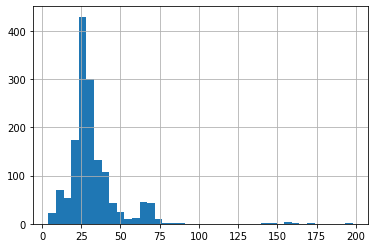

In [13]:
# Норм - многое даже укладывается в 32 слова
df_test = pd.read_csv(os.path.join(args['data_dir'], 'new_test.csv'), index_col=0)
df_test.text.str.split().str.len().hist(bins=40)

### Prepare model

In [ ]:
# fname = "finetuned_pytorch_model.bin"
# output_model_file = os.path.join(args['output_dir'], fname)

fname = "finetuned_pytorch_model_32_ep5.bin"
output_model_file = os.path.join('/content/gdrive/MyDrive/data/news_cat/model', fname)

bert_model = model.get_model(model_path=output_model_file, 
                             bert_model=args['bert_model'], 
                             num_labels=args['num_labels'])
bert_model.to(args['device'])

### Predict

In [19]:
# Results - "вероятности" классов
# Raw_logits - скоры для каждого класса (которые затем превращены в "вероятности" с помощью софтмакса)
# embeddings - эмбеддинги (сжатые представления) текстов в векторном виде (размерность 768; если много, можно в условный PCA закинуть и понизить размерность)
result, raw_logits, embeddings = evals.predict(bert_model, 'new_test.csv', processor, tokenizer, args)

Prediction Iteration:   0%|          | 0/12 [00:00<?, ?it/s]

In [20]:
df_preds = df_test.copy()
df_preds['predicted'] = result.columns[result.values.argmax(axis=1)]
df_preds

,id,title,description,Main,Tags,tag_num,text,predicted
0,2090,Biodiversity: What is it and how are we protec...,The planet is experiencing its sixth mass exti...,World,"Entertainment,UK,World",3,Biodiversity: What is it and how are we protec...,ENVIRONMENT
1,2091,Amazon union election: Will this former worker...,Workers in three Amazon warehouses are decidin...,World,"Entertainment,UK,World",3,Amazon union election: Will this former worker...,BUSINESS
2,2092,Ukraine crisis: Why India is buying more Russi...,Imports of cheaper Russian oil by India are ri...,World,"Entertainment,UK,World",3,Ukraine crisis: Why India is buying more Russi...,WORLD NEWS
3,2093,French election: Why the small town of Moissac...,The relationship between a Bulgarian community...,World,"Entertainment,UK,World",3,French election: Why the small town of Moissac...,WORLD NEWS
4,2096,Roman Abramovich suffered 'suspected poisoning...,The billionaire had sore eyes and peeling skin...,World,"Entertainment,UK,World",3,Roman Abramovich suffered 'suspected poisoning...,WORLD NEWS
...,...,...,...,...,...,...,...,...
1486,2313,Second 'black box' found in China Eastern plan...,The second “black box” has been recovered from...,NaN,World,1,Second 'black box' found in China Eastern plan...,WORLD NEWS
1487,2314,Biden calls for Western unity as Russia suffer...,President Joe Biden called on the world to uni...,NaN,World,1,Biden calls for Western unity as Russia suffer...,POLITICS
1488,2315,"Russian forces damage Holocaust memorial site,...",Russian forces fired on and damaged the Drobit...,NaN,World,1,"Russian forces damage Holocaust memorial site,...",WORLD NEWS
1489,2316,WWII created generations of trauma in their fa...,When Liz Prager O’Brien was growing up in Rhod...,NaN,World,1,WWII created generations of trauma in their fa...,POLITICS


In [ ]:
df_preds.to_csv(os.path.join(args['data_dir'], 'test_preds.csv'), index=None)
result.to_csv(os.path.join(args['data_dir'], 'result.csv'), index=None)
raw_logits.to_csv(os.path.join(args['data_dir'], 'raw_logits.csv'), index=None)
embeddings.to_csv(os.path.join(args['data_dir'], 'embeddings.csv'), index=None)